# MAE6226 Homework 10

Li Lin

In [207]:
import math
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import integrate

## Problem 1

In [113]:
class Panel:
    """Contains information related to a panel."""
    def __init__(self, xa, ya, xb, yb):
        """Initializes the panel.
        
        Arguments
        ---------
        xa, ya -- coordinates of the first end-point of the panel.
        xb, yb -- coordinates of the second end-point of the panel.
        """
        self.xa, self.ya = xa, ya
        self.xb, self.yb = xb, yb
        
        self.xc, self.yc = (xa+xb)/2, (ya+yb)/2       # control-point (center-point)
        self.length = math.sqrt((xb-xa)**2+(yb-ya)**2)     # length of the panel
        
        # orientation of the panel (angle between x-axis and panel's normal)
        if xb-xa <= 0.:
            self.beta = math.acos((yb-ya)/self.length)
        elif xb-xa > 0.:
            self.beta = math.pi + math.acos(-(yb-ya)/self.length)
        
        self.n = [math.cos(self.beta),math.sin(self.beta)]
        self.t = [-math.sin(self.beta),math.cos(self.beta)]
        
        self.sigma = 1                              # source strength
        self.vt = 0                                 # tangential velocity
        self.cp = 0                                 # pressure coefficient

In [114]:
def get_source_panel_velocity(p,x,y,sigma):
    """Evaluates the velocity components induced at coordinates (x,y) by a panel p.
    
    Arguments
    ---------
    p -- panel from which the velocity is induced
    x -- x-coordinate in global frame
    y -- y-coordinate in global frame
    
    Returns
    -------
    (u,v)-components of velocity at (x,y)
    """
    
    x_p =  math.sin(p.beta)*(x-p.xb) - math.cos(p.beta)*(y-p.yb)
    y_p =  math.cos(p.beta)*(x-p.xb) + math.sin(p.beta)*(y-p.yb)
    
    u_p = sigma/(4*math.pi)*np.log((x_p**2+y_p**2)/((x_p-p.length)**2+y_p**2))
    v_p = sigma/(2*math.pi)*(np.arctan2(y_p,x_p-p.length) - np.arctan2(y_p,x_p))
    
    u = +math.sin(p.beta)*u_p + math.cos(p.beta)*v_p
    v = -math.cos(p.beta)*u_p + math.sin(p.beta)*v_p
    
    return u_p,v_p,u,v

In [115]:
def cylinder(panelnum):
        
    theta = 2*math.pi/panelnum 
    r = 1.0
    pxa = np.zeros(panelnum)
    pxb = np.zeros(panelnum)
    pya = np.zeros(panelnum)
    pyb = np.zeros(panelnum)
    for pn in range (panelnum):
        pxa[pn] = r*math.cos(theta*pn)
        pya[pn] = r*math.sin(theta*pn)
        pxb[pn] = r*math.cos(theta*(pn+1))
        pyb[pn] = r*math.sin(theta*(pn+1))
    pxb[panelnum-1] = pxa[0]
    pyb[panelnum-1] = pya[0]

    return pxa,pya,pxb,pyb


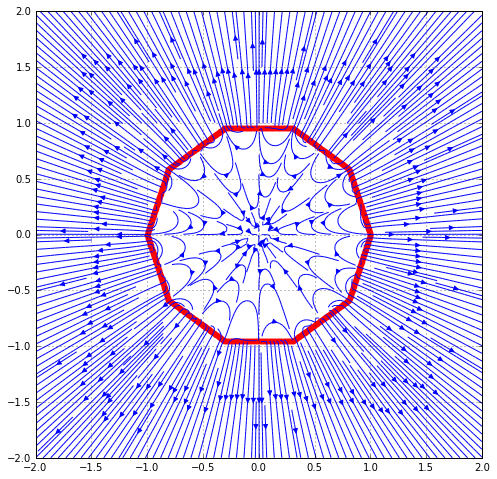

In [116]:
panelnum = 10
pxa,pya,pxb,pyb = cylinder(panelnum)
N = 100
x0,xn = -2.0,2.0
y0,yn = -2.0,2.0
x = np.linspace(x0,xn,N)
y = np.linspace(y0,yn,N)
X,Y = np.meshgrid(x,y)
plt.figure(figsize = (8,8))
plt.xlim(-2.0,2.0)
plt.ylim(-2.0,2.0)
plt.grid('on')
u = np.zeros((N, N), dtype=float)
v = np.zeros((N, N), dtype=float)
utemp = np.zeros((N, N), dtype=float)
vtemp = np.zeros((N, N), dtype=float)
uptemp = np.zeros((N, N), dtype=float)
vptemp = np.zeros((N, N), dtype=float)
p = np.empty(panelnum, dtype=object)
for pn in range (panelnum):
    p[pn] = Panel(pxa[pn],pya[pn],pxb[pn],pyb[pn])
    #print(p[pn].xc)
    for i in range (N):
        for j in range (N):
            uptemp[i,j], vptemp[i,j],utemp[i,j], vtemp[i,j] = get_source_panel_velocity(p[pn],X[i,j],Y[i,j],1.0)
    u = u+utemp
    v = v+vtemp
    px = np.linspace(pxa[pn],pxb[pn],100)
    py = np.linspace(pya[pn],pyb[pn],100)
    plt.scatter (px,py,color = 'red')

plt.streamplot (X,Y,u,v,density = 4);

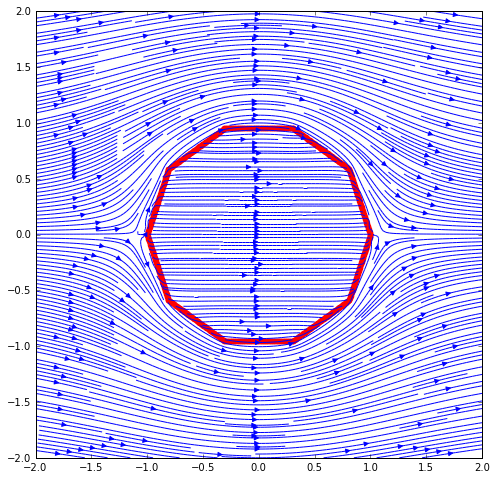

In [117]:
U_inf = 1.0
AOA = 0.0/180.0*math.pi
u = np.zeros((N, N), dtype=float)
v = np.zeros((N, N), dtype=float)
utemp2 = 0.0
vtemp2 = 0.0
uptemp2 = 0.0
vptemp2 = 0.0
A_matrix = np.empty((panelnum,panelnum),dtype=float)
b_vector = np.zeros(panelnum,dtype=float)
x_vector = np.zeros(panelnum,dtype=float)
for pn1 in range (panelnum):
    for pn2 in range (panelnum):
        uptemp2,vptemp2,utemp2,vtemp2 =  get_source_panel_velocity(p[pn2],p[pn1].xc,p[pn1].yc,1.0)
        A_matrix[pn1,pn2] = np.dot([utemp2,vtemp2],p[pn1].n)
    b_vector[pn1] = -np.dot([U_inf*np.cos(AOA),U_inf*np.sin(AOA)],p[pn1].n)
for k in range (panelnum):
    A_matrix[k,k] = 0.5
x_vector = np.linalg.solve(A_matrix,b_vector)
#print('x = ')
#print(x_vector)
#print('A = ')
#print(A_matrix)
#print('b = ')
#print(b_vector)
plt.figure(figsize = (8,8))
plt.xlim(-2.0,2.0)
plt.ylim(-2.0,2.0)
u = np.ones((N, N), dtype=float)
v = np.ones((N, N), dtype=float)
utemp = np.zeros((N, N), dtype=float)
vtemp = np.zeros((N, N), dtype=float)
uptemp = np.zeros((N, N), dtype=float)
vptemp = np.zeros((N, N), dtype=float)
u = u*U_inf*np.cos(AOA)
v = v*U_inf*np.sin(AOA)
for pn in range (panelnum):
    for i in range (N):
        for j in range (N):
            uptemp[i,j], vptemp[i,j],utemp[i,j], vtemp[i,j] = get_source_panel_velocity(p[pn],X[i,j],Y[i,j],x_vector[pn])
    u = u+utemp
    v = v+vtemp
    px = np.linspace(pxa[pn],pxb[pn],100)
    py = np.linspace(pya[pn],pyb[pn],100)
    plt.scatter (px,py,color = 'red')
plt.streamplot (X,Y,u,v,density = 4);

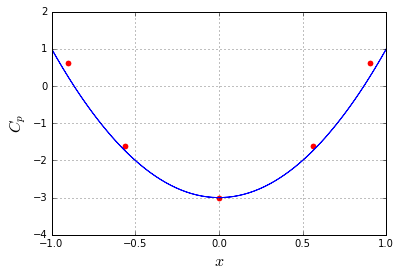

In [118]:
utemp2 = 0.0
vtemp2 = 0.0
uptemp2 = 0.0
vptemp2 = 0.0
vt = np.zeros(panelnum)
cp = np.zeros(panelnum)
xaxis = np.zeros(panelnum)
for pn1 in range (panelnum):
    p[pn1].vt = 0.0
    for pn2 in range (panelnum):
        uptemp2,vptemp2,utemp2,vtemp2 =  get_source_panel_velocity(p[pn2],p[pn1].xc,p[pn1].yc,x_vector[pn2])
        vt[pn1] = vt[pn1]+np.dot([utemp2,vtemp2],p[pn1].t)
        xaxis[pn1] = p[pn1].xc
    vt[pn1] = vt[pn1]+np.dot([U_inf*np.cos(AOA),U_inf*np.sin(AOA)],p[pn1].t)
    p[pn1].vt = vt[pn1]
    cp[pn1] = 1.0-(vt[pn1]/U_inf)**2.0
    p[pn1].cp = cp[pn1]
cpup = np.zeros(int(panelnum/2))
cpdown = np.zeros(int(panelnum/2))
for n in range (int(panelnum/2)):
    cpup[n] = p[n].cp
    cpdown[int(n-panelnum/2.0)] = -p[n].cp
plt.scatter(xaxis,cp,color = 'red')
theta = np.linspace(0,2*math.pi,200)
xcp = 1.0*np.cos(theta)
plt.plot(xcp,1-4*(np.sin(theta))**2.0);
plt.grid('on')
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$C_p$', fontsize=16)
plt.xlim(-1.0,1.0);

## Problem 2

In [119]:
def JT(zeta, c):
    
    z = zeta+c**2/zeta
    
    return z

In [120]:
def Solve_m_delta(H,T):
    
    delta = math.atan(H/T*3*math.sqrt(3)/2)
    if delta<(math.pi/2):
        delta = math.pi-delta
    m = abs(T/(3*math.sqrt(3))/math.cos(delta))
    
    return delta, m

In [192]:
def BuildFoil(delta, m, l, panelnum):
    
    c = l/4
    epsilon = m/c
    r0 = math.sqrt(m**2+c**2-2*m*c*math.cos(delta))
    Nr = 1
    Ngamma = 500
    rn = 0.8
    r = np.linspace(r0, rn, Nr)
    gamma = np.linspace(0, 2*math.pi, Ngamma)
    R, Gamma = np.meshgrid(r, gamma)
    zeta = R*np.exp(1j*Gamma)+m*np.exp(1j*delta)
    z = JT(zeta, c)
    
    Nr = 1
    Ngamma = panelnum*2+1
    rn = 0.8
    r = np.linspace(r0, rn, Nr)
    gamma = np.linspace(0, 2*math.pi, Ngamma)
    R, Gamma = np.meshgrid(r, gamma)
    zeta = R*np.exp(1j*Gamma)+m*np.exp(1j*delta)
    z20 = JT(zeta, c)
    
    return z, z20, zeta

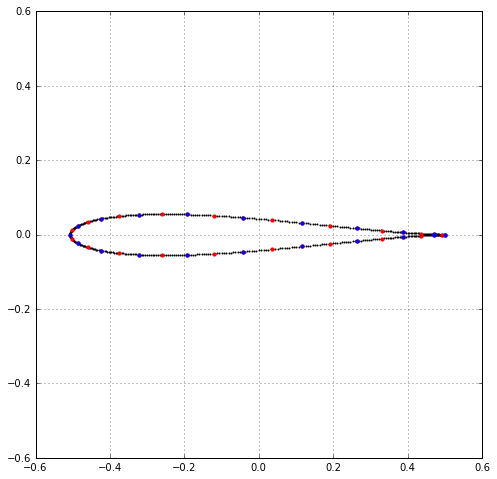

In [194]:
l = 1
T = 0.12
H = 0.00
panelnum = 20
delta, m = Solve_m_delta(H,T)
z, z20, zeta = BuildFoil(delta, m, l, panelnum)
pxa = np.zeros(panelnum)
pxb = np.zeros(panelnum)
pya = np.zeros(panelnum)
pyb = np.zeros(panelnum)
for pn in range (int(panelnum*2+1)):
    if (pn%2 == 0) and (pn <= panelnum*2-1):
        pxa[int(pn/2)] = z20[pn].real
        pya[int(pn/2)] = z20[pn].imag

for pn in range (panelnum-1):
    pxb[pn] = pxa[pn+1]
    pyb[pn] = pya[pn+1]
pxb[panelnum-1] = pxa[0]
pyb[panelnum-1] = pya[0]
fsize = 8
plt.figure(figsize=(fsize, fsize))
plt.xlim(-0.6, 0.6)
plt.ylim(-0.6, 0.6)
plt.scatter(z.real, z.imag, s = 1)
plt.scatter(z20.real,z20.imag, s = 10, color = 'red')
plt.scatter(pxa,pya,s = 10,color = 'blue');
plt.grid('on')

x = 
[-0.02625414 -0.05951229 -0.09018285 -0.10964029 -0.10969989 -0.08092882
 -0.01280446  0.11255996  0.35533052  1.07562439  1.07562439  0.35533052
  0.11255996 -0.01280446 -0.08092882 -0.10969989 -0.10964029 -0.09018285
 -0.05951229 -0.02625414]


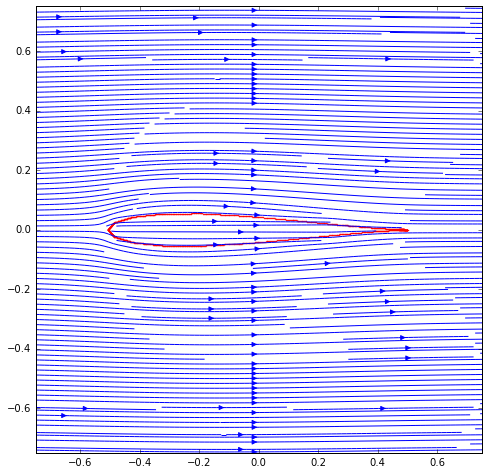

In [187]:
N = 100
x0,xn = -2.0,2.0
y0,yn = -2.0,2.0
x = np.linspace(x0,xn,N)
y = np.linspace(y0,yn,N)
X,Y = np.meshgrid(x,y)
U_inf = 1.0
AOA = 0.0/180.0*math.pi
u = np.zeros((N, N), dtype=float)
v = np.zeros((N, N), dtype=float)
p = np.empty(panelnum, dtype=object)
for pn in range (panelnum):
    p[pn] = Panel(pxa[pn],pya[pn],pxb[pn],pyb[pn])
utemp2 = 0.0
vtemp2 = 0.0
uptemp2 = 0.0
vptemp2 = 0.0
A_matrix = np.empty((panelnum,panelnum),dtype=float)
b_vector = np.zeros(panelnum,dtype=float)
x_vector = np.zeros(panelnum,dtype=float)
for pn1 in range (panelnum):
    for pn2 in range (panelnum):
        uptemp2,vptemp2,utemp2,vtemp2 =  get_source_panel_velocity(p[pn2],p[pn1].xc,p[pn1].yc,1.0)
        A_matrix[pn1,pn2] = np.dot([utemp2,vtemp2],p[pn1].n)
    b_vector[pn1] = -np.dot([U_inf*np.cos(AOA),U_inf*np.sin(AOA)],p[pn1].n)
for k in range (panelnum):
    A_matrix[k,k] = 0.5
x_vector = np.linalg.solve(A_matrix,b_vector)
print('x = ')
print(x_vector)
#print('A = ')
#print(A_matrix)
#print('b = ')
#print(b_vector)
plt.figure(figsize = (8,8))
plt.xlim(-0.75,0.75)
plt.ylim(-0.75,0.75)
u = np.ones((N, N), dtype=float)
v = np.ones((N, N), dtype=float)
utemp = np.zeros((N, N), dtype=float)
vtemp = np.zeros((N, N), dtype=float)
uptemp = np.zeros((N, N), dtype=float)
vptemp = np.zeros((N, N), dtype=float)
u = u*U_inf*np.cos(AOA)
v = v*U_inf*np.sin(AOA)
for pn in range (panelnum):
    for i in range (N):
        for j in range (N):
            uptemp[i,j], vptemp[i,j],utemp[i,j], vtemp[i,j] = get_source_panel_velocity(p[pn],X[i,j],Y[i,j],x_vector[pn])
    u = u+utemp
    v = v+vtemp
    px = np.linspace(pxa[pn],pxb[pn],100)
    py = np.linspace(pya[pn],pyb[pn],100)
    plt.scatter (px,py,color = 'red',s = 0.1)
plt.streamplot (X,Y,u,v,density = 8);


/home/gil/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:56: RuntimeWarning: invalid value encountered in true_divide


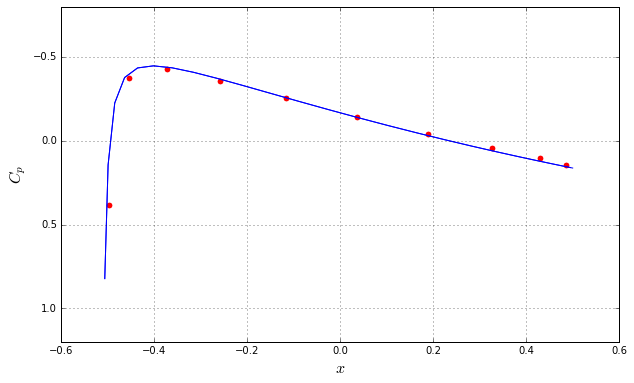

In [343]:
utemp2 = 0.0
vtemp2 = 0.0
uptemp2 = 0.0
vptemp2 = 0.0
vt = np.zeros(panelnum)
cp = np.zeros(panelnum)
xaxis = np.zeros(panelnum)
for pn1 in range (panelnum):
    p[pn1].vt = 0.0
    for pn2 in range (panelnum):
        uptemp2,vptemp2,utemp2,vtemp2 =  get_source_panel_velocity(p[pn2],p[pn1].xc,p[pn1].yc,x_vector[pn2])
        vt[pn1] = vt[pn1]+np.dot([utemp2,vtemp2],p[pn1].t)
        xaxis[pn1] = p[pn1].xc
    vt[pn1] = vt[pn1]+np.dot([U_inf*np.cos(AOA),U_inf*np.sin(AOA)],p[pn1].t)
    p[pn1].vt = vt[pn1]
    cp[pn1] = 1.0-(vt[pn1]/U_inf)**2.0
    p[pn1].cp = cp[pn1]
plt.figure(figsize = (10,6))
plt.scatter(xaxis,cp,color = 'red')
plt.grid('on')
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$C_p$', fontsize=16)
plt.ylim(1.2,-0.8);

# Define polar grid
ngr = 12;
ngtheta = 50

# airfoil properties
c = 1
T = 0.12
H = 0.00
a = c/4
r_s = (0.25+T/(3*math.sqrt(3)))
zeta_c = -4*a/(3*math.sqrt(3))*T + 1j*2*a*H

theta = np.radians(np.linspace(0,360,ngtheta));
r = np.linspace(r_s,2*r_s,ngr);

R, Theta = np.meshgrid(r, theta)
Zeta = R*np.exp(1j*Theta)

# flow parameters
Uinf = 1.0                                     # free stream velocity
al = 0.0*math.pi/180                           # angle of attack
kappa = 2*math.pi*Uinf*r_s**2                  # doublet strength for circle with radius r_s
Gam = 4*math.pi*r_s*Uinf*np.sin(al+2*H)     # vortex strength

# compute the complex potential on the mesh grid and complex velocity on the surface
W = Uinf*Zeta + kappa/(2*math.pi)/Zeta + 1j*Gam/(2*math.pi)*np.log(Zeta)
w = Uinf - kappa/(2*math.pi)/Zeta[:,0]**2 + 1j*Gam/(2*math.pi)/Zeta[:,0]
Zeta = Zeta*np.exp(1j*al)

# Joukowski transformation
Z = (Zeta+zeta_c) + a**2/(Zeta+zeta_c)
w = w/(1 - a**2/(Zeta[:,0]+zeta_c)**2)
cp = 1 - np.abs(w)**2/Uinf**2
plt.plot(Z.real[:25,0],cp[:25],'b')
plt.plot(Z.real[25:,0],cp[25:],'b');


## Problem 3

In [280]:
total_sigma = 0
total_length = 0
for pn in range (panelnum):
    total_sigma = total_sigma+x_vector[pn]*p[pn].length
    total_length = total_length+p[pn].length

velocity_out = total_sigma/total_length
rho = 1.0
flux = velocity_out*rho
print(flux)

0.00456709479905


The total flux should be zero. Since there is no normal velocity pointing out on the panels, there is no extra flux generated by the panels added into the flow field.